# TMMOB Makine Mühendisleri Odası
## Yapay Öğrenme Uygulama Çalışmaları

<div class='text-justify'> Bu çalışmamızda, Bilgisayar Destekli Sayısal Kontrol (CNC) ile üretim uygulamalarında en yaygın yapılan çalışmalardan birisi olan takım aşınması ile ilgili çalışma yapacağız. </div>

<div class='text-justify'> </div>
 

In [ ]:
# Gerekli kütüphanelerin çağrılması

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR


In [ ]:
# Dosyanın açılması
def open_file(filename):
  dataframe=pd.read_csv(filename)
  return dataframe

In [ ]:
# Malzemenin Etiket Şifrelenmesi
def label_encode(dataframe):
  headings=dataframe.columns
  material=list(dataframe.iloc[:,-1].values)
  count=0
  material_type={}

  # Malzeme Sınıflarını Belirleme
  for i in range(len(material)-1):
    if material[i]==material[i+1]:
      count=count+1
      material_type[material[i]]=count
    else:
      count=0

  # Malzemelerin Etiket Kodlaması
  material_new=[]

  for i in range(len(material)):
    if material[i]=='Steel':
      material_new.append(1)
    else:
      material_new.append(2)
  
  df=dataframe.iloc[:,:-1].values
  df=np.column_stack((df,material_new))
  df=pd.DataFrame(df,columns=headings)

  return material_type,df

In [ ]:
# Verinin Hazırlanması
def define_data(dataframe):
  
  # İstatistik Analizleri
  headings=list(dataframe.columns)
  # print(dataframe.describe())
  column_number=headings.index('VB')
  dependent=dataframe.iloc[:,column_number].values
  independent=dataframe.iloc[:,column_number+1:].values
  independent_df=pd.DataFrame(independent,columns=headings[column_number+1:])

  #Korelasyon Matrisi ile Öznitelik Seçimi
  # sns.heatmap(independent_df.corr(),annot=True)

  return independent,dependent

In [ ]:
df1=open_file('train.csv')
df2=open_file('test.csv')

ind,dep=define_data(df1)
print(ind)

ParserError: ignored

In [ ]:
# Verinin Eğitim ve Doğrulama Olarak İkiye Bölünmesi, Test Verisinin Oluşturulması
def seperate(dataframe,percent):
  independent,dependent=define_data(dataframe)
  xtrain,xtest,ytrain,ytest=train_test_split(independent,dependent,test_size=percent,shuffle=True,random_state=None)
  return xtrain,xtest,ytrain,ytest

def split(dataframe):
  independent,dependent=define_data(dataframe)
  return independent.iloc[:,:].values,dependent.iloc[:,:].values

def test(dataframe):
  headings=list(dataframe.columns)
  nan,df=label_encode(dataframe)
  ind_test,dep_test=define_data(df)
  ind_test=pd.DataFrame(ind_test,columns=headings[3:])
  return ind_test

In [ ]:
# YSA Modelinin Oluşturulması
def ann_model(x_train,x_test,y_train,y_test,dataframe2,percent):

  sc=StandardScaler()
  x_train=sc.fit_transform(x_train)
  x_test=sc.transform(x_test)

  function='relu'
  model=Sequential()
  model.add(Dense(units=2*len(x_train[0]),input_dim=len(x_train[0]),kernel_initializer = 'uniform',activation=function))
  model.add(Dense(units=3*len(x_train[0]),input_dim=2*len(x_train[0]),kernel_initializer = 'uniform',activation=function))
  model.add(Dense(units=3*len(x_train[0]),input_dim=3*len(x_train[0]),kernel_initializer = 'uniform',activation=function))
  model.add(Dense(units=2*len(x_train[0]),input_dim=3*len(x_train[0]),kernel_initializer = 'uniform',activation=function))
  model.add(Dense(units=1,input_dim=2*len(x_train[0]),kernel_initializer = 'uniform',activation='relu'))
  model.compile(optimizer='adam',loss='mse',metrics=['mse'])
  history=model.fit(x_train,y_train,batch_size=16,epochs=100)

  results=model.predict(x_test)
  results_new=np.column_stack((y_test,results))
  results_new=pd.DataFrame(results_new,columns=['Test Value (ANN)','Results (ANN)']).sort_values('Test Value (ANN)') 
  mse=history.history['mse']

  epochs=list(range(1,len(mse)+1))

  plt.figure('MSE for Deep Learning Model')
  plt.plot(epochs,mse,'-b')
  plt.grid(True)
  plt.title('MSE for Deep Learning Model')
  plt.xlabel('Epochs')
  plt.ylabel('MSE (Units of Square)')
  plt.show()

  plt.figure('Model Prediction of ANN')
  slope,intercept,r_value,p_value,std_err=linregress(results_new.iloc[:,0].values,results_new.iloc[:,1].values)    
  plt.plot(results_new.iloc[:,0].values,results_new.iloc[:,1].values,'*b')
  plt.grid(True)
  plt.title('Model=> y={:.3f}x+{:.3f}'.format(slope,intercept))
  plt.xlabel('Test Value')
  plt.ylabel('Model Prediction')
  plt.show()

  # Test Verisi
  test_df=test(dataframe2)
  x0_1=test_df.iloc[:,:].values
  x0_1=sc.transform(x0_1)
  results2=model.predict(x0_1)

  return results_new,results2,mse

In [ ]:
# Destek Vektör Makineleri Temelli Takım Aşınma Analizi

def SVRegressor(x_train,x_test,y_train,y_test,dataframe2,percent):

  sc=StandardScaler()
  x_train=sc.fit_transform(x_train)
  x_test=sc.transform(x_test)

  regressor=SVR(kernel='rbf')1
  regressor.fit(x_train,y_train)

  results_svr=regressor.predict(x_test)
  results_new_svr=np.column_stack((y_test,results_svr))
  results_new_svr=pd.DataFrame(results_new_svr,columns=['Test Value (SVR)','Results (SVR)']).sort_values('Test Value (SVR)') 

  plt.figure('Model Prediction of SVR')
  slope,intercept,r_value,p_value,std_err=linregress(results_new_svr.iloc[:,0].values,results_new_svr.iloc[:,1].values)    
  plt.plot(results_new_svr.iloc[:,0].values,results_new_svr.iloc[:,1].values,'*r')
  plt.grid(True)
  plt.title('Model=> y={:.3f}x+{:.3f}'.format(slope,intercept))
  plt.xlabel('Test Value')
  plt.ylabel('Model Prediction')
  plt.show()

  # Test Verisi
  test_df=test(dataframe2)
  x0_1=test_df.iloc[:,:].values
  x0_1=sc.transform(x0_1)
  results2_svr=regressor.predict(x0_1)

  return results_new_svr,results2_svr

In [ ]:
df=open_file('train.csv')
df.head()

,Case,run,VB,Time,DOC,Feed,Material
0,1,1,0.00,2,1.5,0.5,Steel
1,1,4,0.11,7,1.5,0.5,Steel
2,1,6,0.20,15,1.5,0.5,Steel
3,1,7,0.24,19,1.5,0.5,Steel
4,1,8,0.29,22,1.5,0.5,Steel


In [ ]:
material,classified=label_encode(df)
classified.head()

,Case,run,VB,Time,DOC,Feed,Material
0,1.0,1.0,0.00,2.0,1.5,0.5,1.0
1,1.0,4.0,0.11,7.0,1.5,0.5,1.0
2,1.0,6.0,0.20,15.0,1.5,0.5,1.0
3,1.0,7.0,0.24,19.0,1.5,0.5,1.0
4,1.0,8.0,0.29,22.0,1.5,0.5,1.0


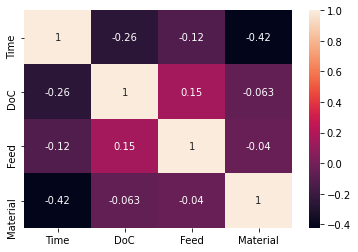

In [ ]:
ind,dep=define_data(classified)

ind=pd.DataFrame(ind,columns=['Time','DoC','Feed','Material'])
sns.heatmap(ind.corr(),annot=True)

Epoch 1/100
9/9 [==============================] - 2s 2ms/step - loss: 0.1671 - mse: 0.1671
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1614 - mse: 0.1614
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1737 - mse: 0.1737
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1566 - mse: 0.1566
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1305 - mse: 0.1305
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1315 - mse: 0.1315
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1358 - mse: 0.1358
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1271 - mse: 0.1271
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1054 - mse: 0.1054
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1203 - mse: 0.1203
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0900 

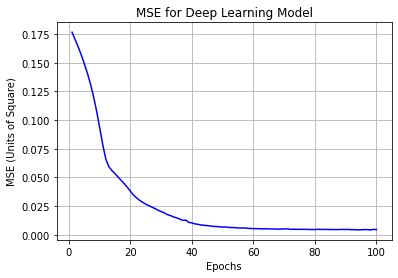

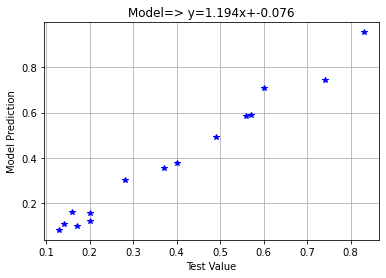

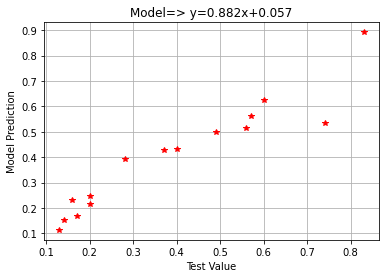

    Test Value (ANN)  Results (ANN)
14              0.13       0.082225
11              0.14       0.106575
2               0.16       0.159494
6               0.17       0.098757
1               0.20       0.121206
13              0.20       0.154636
12              0.28       0.304567
7               0.37       0.356231
9               0.40       0.377239
3               0.49       0.490623
8               0.56       0.586633
0               0.57       0.590788
4               0.60       0.709397
10              0.74       0.745109
5               0.83       0.954091
New Results (ANN)
[[0.09847026]
 [0.10158363]
 [0.11042486]
 [0.56700015]
 [0.10823619]
 [0.09600192]
 [0.280895  ]
 [0.3920892 ]
 [0.07577821]
 [0.09093336]
 [0.34245962]
 [0.5199683 ]
 [0.3280959 ]
 [0.0748411 ]
 [0.07669311]
 [0.12528989]
 [0.4331377 ]
 [0.10093844]
 [0.21232189]
 [0.24338861]
 [0.3087358 ]]
    Test Value (SVR)  Results (SVR)
14              0.13       0.113434
11              0.14       0.153421
2  

In [ ]:
# Ana Program

if __name__=='__main__':
  df=open_file('train.csv')
  df1=open_file('test.csv')
  percent=0.1
  material,classified=label_encode(df)
  x_train,x_test,y_train,y_test=seperate(classified,percent)
  results,results_nan,mse=ann_model(x_train,x_test,y_train,y_test,df1,percent)
  results_svr,results_nan_svr=SVRegressor(x_train,x_test,y_train,y_test,df1,percent)
  print(results)
  print('New Results (ANN)')
  print(results_nan)

  print(results_svr)
  print('New Results (SVR)')
  print(results_nan_svr)